# Welcome to the Matrix Element Tutorial for the LPC EFT Workshop!

We will be using the JHUGenMELA framework, which was developed (among other locations) at Johns Hopkins. Please reference the website located [here](https://spin.pha.jhu.edu/)

![logo.png](https://spin.pha.jhu.edu/droppedImage.png)

We will be delving into the usage of matrix-element techniques to retrieve **both** optimal observables for different hypotheses at reconstruction-level for physics analyses, as well as reweighting techniques to allow for quicker generation of new hypotheses.

**THIS NOTEBOOK WILL BE DEALING WITH HOW TO INITIALIZE MELA AND USE IT TO GENERATE WEIGHTS AND RE-WEIGHT AT GEN-LEVEL. WHILE IT WILL BE TOUCHED UPON, GO TO PART 2 TO UNDERSTAND OBSERVABLES**

## Setup

Environment variables are very important to setting up JHUGenMELA - let's check all of them before you start!

**PLEASE FOLLOW THE INSTRUCTIONS IN README.md TO SET UP WHAT IS REQUIRED HERE**

In [ ]:
import os
import sys
import ipywidgets as widgets
from IPython.display import Image, display
import helpers
import importlib
importlib.reload(helpers)

In [ ]:
tracker = helpers.TrackProgress_MELA()

### These lines help us debug what could be going wrong

In [ ]:
print(os.getcwd())

In [ ]:
print(os.environ["CMSSW_BASE"])

In [ ]:
print(os.environ['MELA_LIB_PATH'])

In [ ]:
assert (
    os.environ['MELA_LIB_PATH']
    == 
    f"{os.environ['CMSSW_BASE']}/src/JHUGenerator.v7.5.7/JHUGenMELA/MELA/data/el9_amd64_gcc12"
)

In [ ]:
import uproot
import subprocess
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import enum
import hist
import tqdm
import pprint

# What is the "Matrix Element"?

Recall your grad-level QFT course - remember the S-matrix? To quote Weinberg QFT, "The S-matrix $S_{\beta\alpha}$ is the probability amplitude for the transition $\alpha\rightarrow\beta$". This S-matrix is the namespace of the "Matrix-Element Method".

This excerpt might make things clearer, from Mark Thomson's *Modern Particle Physics*: 
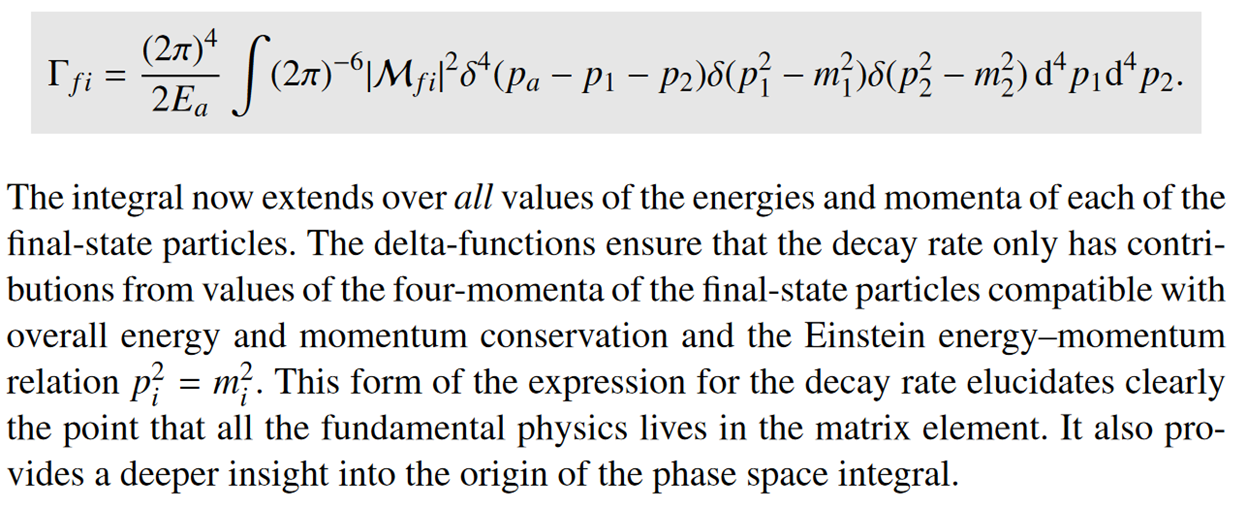

While this is the case for decays to final-state particle $f$ from initial state particle $i$, we can also include PDF weights to sum over initial states to get production-dependent "matrix elements" (not really matrix elements, but functionally the same thing for our purposes).

For well-defined processes where nice theorists have already calculated these matrix elements for a variety of different interactions, such as $H\rightarrow ZZ$ decays, these matrix elements are invaluable.

# Weights in Physics

Weighted histograms appear everywhere in HEP! Generators often produce weighted histograms that show a distribution as opposed to unweighted events one-by-one, as that is much faster. Really what they are is a representation of how many events you expect in whatever phasespace you expect.

Madgraph, and every generator at higher-orders utilize weights to do real physics. In the realm of EFT, we can use these weights to ascribe very specific meaning to show how one hypothesis can shift to another.

### Relation to the Matrix-Element

In NLO/NNLO/NN(...)LO generators, oftentimes events will have specific weights attached to them to showcase the relative contribution of specific events. This is why negative weights are sometimes an issue, as sometimes interference will drop the yield due to NLO effects. **Keep in mind, due to this (among other issues) - reweighting at NLO/NNLO/etc. is really unwieldy. We will be doing this at LEADING-ORDER**.

In this case, what you're really doing is **replacing** the matrix-element that describes your sample hypothesis, with the one that describes the physics that you want. **As long as your initial state and your final state are the same, you can nominally reweight to anything that you would like**. This is why ***Reweighting can only be done with gen-level quantities***.

Let's assume that your sample starts with some hypothesis $P_{\text{SAMPLE}}$, which is the result of some set of couplings. Now, let's say you start at Gen level and want a sample $P_{\text{TARGET}}$, you would do the following:

1. Compute $P_{\text{SAMPLE}}$ for each event
2. Compute $P_{\text{TARGET}}$ for each event
3. Apply $w=\frac{P_{\text{TARGET}}}{P_{\text{SAMPLE}}}$ to each event to re-weight the sample

### Let's do a stupid example!

Let's imagine that the entirety of the information here is contained within these histograms for $P_{\text{SAMPLE}}$ and $P_{\text{TARGET}}$, and the "weight" is just the ratio of the 2 histograms. Notice that re-weighting is really only successful when **the two samples share some sort of phase space**. Background can be reweighted to signal, but signal cannot recreate background!

**When re-weighting, it is important that you use a variety of different samples such that you can sample the entire phase-space of the hypothesis you are re-weighting to**.

In [ ]:
fig, axs = plt.subplots(1,3,layout="constrained", figsize=(30,7), sharey=True)
EFT_signal = np.random.normal(125, 0.5, 100)
background = 110 + 25*np.random.exponential(0.5, 2500)
binning = np.linspace(110, 135, 25)

EFT_signal_hist, _ = np.histogram(EFT_signal, binning)
background_hist, _ = np.histogram(background, binning)

hep.histplot(
    [background_hist, EFT_signal_hist], binning, 
    label=["Background", "Signal"], ax=axs[0], lw=3, linestyle=["solid", "dashed"]
)

#USING THE HISTOGRAM COUNTS FOR "EFT SIGNAL" AND "BACKGROUND" AS YOUR "PROBABILITY", 
#RE-WEIGHT EACH ONE TO LOOK LIKE THE OTHER
#Use the assert check as a hint!

wgt_sig_to_bkg = 0
wgt_bkg_to_sig = 0

hep.histplot(
    [background_hist, EFT_signal_hist*wgt_sig_to_bkg], binning, 
    label=["Background", "Reweighted Signal"], ax=axs[1], lw=3, linestyle=["solid", "dashed"]
)

hep.histplot(
    [background_hist*wgt_bkg_to_sig, EFT_signal_hist], binning, 
    label=["Reweighted Background", "Signal"], ax=axs[2], lw=3, linestyle=["solid", "dashed"]
)

for ax in axs:
    ax.set_xlim(110, 135)
    ax.legend(fontsize=25, loc="upper right")
    ax.tick_params(labelsize=20)
fig.show()

assert np.array_equal(background_hist*wgt_bkg_to_sig, EFT_signal_hist)
assert np.any(EFT_signal_hist*wgt_sig_to_bkg == background_hist)


# Initializing Your MELA Object

The MELA object is available in both Python and in C++. Both are pre-compiled libraries, with the Python library utilizing PyBind11 in order to create the bindings, which have been available as of July 2024. There are also a slew of other things stored in the Mela Python library, which we will go over!

**Note that there is documentation for JHUGenMELA that is located [on the website](https://spin.pha.jhu.edu/MELA/). Everything that we will be doing pertains to the section called [PyMela](https://spin.pha.jhu.edu/MELA/PyMela_page.html)**.

**We will be referring back to this documentation *constantly*! So please familiarize yourself with it**

In [ ]:
import Mela

The `Mela` package contains a large number of different C++ classes that are required to interface with the underlying FORTRAN functions through the existing MELA functionality. Let's see what they are.

For any python object or module one can call `dir` to see all of its possible attributes.

**call dir on the Mela module below to see everything that is contained within the package. Most of these "classes" are enumerations, but MELACandidate, MELAParticle, MELAThreeBodyDecayCandidate, SimpleParticle_t, and SimpleParticleCollection_t are actual classes**

In [ ]:
dir(Mela)

### How do Enumerations Work?

An enumeration (enum) is just a really fancy way of storing constants that represent *something*. In the case of MELA, all of the enums are integers, and represent different values that are used throughout. 

There are a lot of ways to get the values for a certain enum - let's explore that for a moment

In [ ]:
dir(Mela.VerbosityLevel)

### Try and pass this assert statement

In [ ]:
i = Mela.VerbosityLevel.SILENT
assert i.value == 5 and i.name == "DEBUG_MECHECK"
tracker.enum_pass()

The constructor can be found [here](https://spin.pha.jhu.edu/MELA/MELA_python.html) in Python as an example, with the underlying C++ function found [here](https://spin.pha.jhu.edu/MELA/classMela.html#aa0d92c0d836f7c720f584dc75a8031fc). **Note that all the actual function signatures are documented within the C++ area, as that is where the functions are actually defined**.

In [ ]:
#MELA is initialized as (Center-of-Mass Energy, Higgs Mass, Verbosity)
m = Mela.Mela(13, 125, Mela.VerbosityLevel.SILENT)

Note the number of other people credited! This package is a team effort done across many different generators to try and utilize what is best.

At a glance, the JHUGenerator, MCFM, Madgraph, and SMEFTSim teams are explicitly credited as their matrix elements are used directly.

## Couplings

Couplings define interactions between various particles. In MELA within C++, couplings are stored within arrays and indexed via the couplingIndex enumerations you saw earlier.


The couplings utilized by JHUGen and MCFM are in what is known as the "amplitude basis", which directly affects the amplitudes of various processes for the Higgs boson. There is a conversion to the commonly-used EFT Warsaw Basis, and we will cover that soon.

**This is where things get a little wierd**. MCFM supports 2 resonances (made for high-mass analyses), so many arrays are of dimension (2, N-couplings, 1 or 2), where the first dimension is for each resonance, the second the number of couplings the array contains, and the third either 1 or 2 depending on if the couplings are real only or can also imaginary.


**As an example, let's look at selfDHggcoupl, or the array containing the Higgs coupling to gluons**. These are output as normal numpy ndarrays, and so you can do with them whatever you'd like!

Remember that editing the numpy array without calling `ndarray.copy()` will edit terms in-place.

In [ ]:
#coupling arrays in Mela have to be called as functions since it's retrieving the C-style array
print(m.selfDHggcoupl())
print(m.selfDHggcoupl().shape)

Let's say you want to set `ghg2`, or the point-like approximation of the gluon-fusion loop coupling to the Higgs, to 1, or the Standard Model value. Remember that couplings are set as `array[Resonance_Index][coupling_enum][real/imaginary]`. 

**To help you out, the coupling enum you want to use is `CouplingIndex_HGG.gHIGGS_GG_2`**

In [ ]:
indices = (None, None, None)
m.selfDHggcoupl()[indices] = 0
assert np.array_equal(m.ghg2, [1,0])
coupling_pass()

## DOING THINGS THIS WAY IS A HUGE PAIN!

This is why, just for you, the MELA team devised a series of names for each and every coupling that can be used very easily. You saw this used just above. It is shown how to do that below:
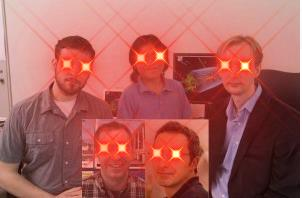
<!-- ![image-2.png](attachment:image-2.png) -->
<sup> Left --> Right </sup>

<sup> Ian Anderson , Ulascan Sarica, Andrei Gritsan (Top) Chris Martin, Roberto Covarelli (Bottom) </sup>

In [ ]:
ghg_array = m.selfDHggcoupl()
m.ghg2 = [1,0]
m.gh2g2 = [1,0]
print("before:")
print(ghg_array)

m.ghg2 = [100,0] #for example
m.gh2g2 = [100,0]
print("after")
print(ghg_array)

### The entire list of couplings that could possibly be used are listed [at this page in the documentation](https://spin.pha.jhu.edu/MELA/MELA_couplings_table.html).

The nomenclature generally goes `g<particle1><particle2><number>`. Usually particle 1 is the Higgs, denoted by `h`, and whenever the number is 1 that indicates the Standard Model coupling. Whenever there is a `2` in front of `h`, that denotes the coupling for the second resonance.

The convention for the Higgs amplitude basis is linked in the following papers: [ArXiv:2002.09888](https://arxiv.org/abs/2002.09888) and [ArXiv:2109.13363](https://arxiv.org/abs/2109.13363).

There are a huge number of couplings, **including** couplings between the Z and fermions, which can be found at the bottom of the table linked in the header belonging to the `selfDAZffcoupl` array.

### Try setting the value of the Standard Model coupling between the Higgs and the Z Boson (which follows the style `g<particle1><particle2><number>`) to be $i$

**It's really easy to cheat here - DON'T DO IT!**

In [ ]:
m.ghz<SOMETHING> = None #change this line!

assert np.array_equal(m.selfDHzzcoupl()[(0, Mela.CouplingIndex_HVV.gHIGGS_VV_1)], [0,1])
tracker.named_coupling_pass()

## But I thought we were doing EFT????

There is a handy tool to convert between the Higgs and Warsaw bases, and that comes in the form of JHUGenLexicon, which is part of the JHUGen package. Currently, it is tuned for Higgs to vector vector decays, so $H\rightarrow ZZ$ and $H\rightarrow WW$. But these relations can hold up more generally.

**The manual for JHUGenLexicon exists in the same place as the JHUGenerator Manual, which is located [here](https://spin.pha.jhu.edu/Manual.pdf)**

### The couplings that are output here are what we will be reweighting to in our example for gluon-fusion

These couplings represent a pure pseudo-scalar (CP-odd) coupling between the Higgs and the Z. You'll notice that ghz4, which represents the CP-odd tensor structure in the Higgs Amplitude basis, is set to 1 with this combination of Wilson Coefficients.

In [ ]:
JHU_lexicon = "CMSSW_14_0_0/src/JHUGenerator.v7.5.7/JHUGenLexicon/JHUGenLexicon"
higgs_basis_conversion = subprocess.check_output([
    JHU_lexicon, 
    "input_basis=warsaw",
#     "HZ_couplings_only=true",
    "output_basis=eft_jhu",
    "tcHW=-6.34078,0",
    "tcHB=-1.90674,0",
    "cHG=-8.24752,0",
    "tcHWB=-6.9542,0",
    "cHbx=-16.495,0"
]).decode('utf-8')
print(higgs_basis_conversion)

## Setting up your MELA object's mode

In order to run properly, we must input the proper production mode and process that we are providing. Similarly, we need to also state the "*matrix element*" we will be using (essentially which generator's calculations are we taking).

Here are generally how the Matrix Elements (and their usage) generally shakes out:

| "Matrix Element" | Usage | Basis |
| ---------------- | ----- | ----- |
| JHUGen           | single-resonance Spin-0, Spin-1, Spin-2 resonances | Higgs Basis |
| MCFM             | single or doubly resonant Spin-0 particles, often used for off-shell $H$ | Higgs Basis |
| Madgraph         | Currently only available for $gg\rightarrow H$ and $q\bar{q}\rightarrow 4\ell$, but will be expanded | Warsaw Basis |

For now, we will be using the MCFM Matrix Elements for gluon fusion.

For the combination of processes and productions that are possible, check [here](https://spin.pha.jhu.edu/MELA/tvar_enums.html). 

**To make your life easier, I am telling you that we will be using Mela.Production.ZZGG and Mela.Process.HSMHiggs**.


In [ ]:
m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.JHUGen, Mela.Production.ZZGG)

# Compute Functions

Mela has 3 compute functions for probabilities - `computeP`, `computeProdP`, and `computeProdDecP`. Use `computeP` for any processes that are decay only, `computeProdP` for production-side reweighting, and `computeProdDecP` for a combination of the two. 

**Every time you call a compute function, the couplings are wiped away! This is because MELA pre-dates columnar analysis formats, so we will have to utilize an event loop**.

In [ ]:
m.ghz1 = [1,0]
m.ghg2 = [1,0]
print(f"Setting ghz1 to {m.ghz1} and ghg2 to {m.ghg2}")
print("The resulting probability is:", m.computeP(False))
print(f"After computation, ghz1 = {m.ghz1} and ghg2 = {m.ghg2}")

# Setting Input Events

The probability is 0 because there were no input events! 

**My personal choice is to pre-compute all the input events, the utilize them in the event loop for multiple different hypotheses**.

Inpute events are set using `Mela.Mela.setInputEvent` (which is based off of the C++ `Mela::setInputEvent`), which takes in a `Mela.SimpleParticleCollection_t`, which is really just a vector made of `SimpleParticle_t`, which is a pair consistent of a PDG ID and a Lorentz Vector. The code in C++ looks as such:

```cpp
typedef std::pair<int, TLorentzVector> SimpleParticle_t;
typedef std::vector<SimpleParticle_t> SimpleParticleCollection_t;
```

The documentation is available for all the following:

- [SimpleParticle_t](https://spin.pha.jhu.edu/MELA/SimpleParticle_t.html)
- [SimpleParticleCollection_t](https://spin.pha.jhu.edu/MELA/SimpleParticleCollection_t.html)
- [Mela::setInputEvent](https://spin.pha.jhu.edu/MELA/classMela.html#a71142f41d44bb42a1cd2be50b3cc8240)


In [ ]:
dir(Mela.SimpleParticleCollection_t)

Here we are simply building an awkward array that represents the output from a single gluon-fusion event coming out of JHUGen. If you want to check out the HATS tutorial on Awkward Arrays, see [here](https://awkward-array.org/doc/main/getting-started/uproot-awkward-columnar-hats.html).
But generally the data is retrieved (in this case) via `ggH_test_data.<field>`. So, if you wanted to access the


### Mela has a bit of a weird naming scheme with regards to what particles are where

* "Mother" particles are the initial state particles that we don't see in reconstruction (so gluons or quarks).
* "Daughter" particles are the final-state leptons or whatever from the hard scattering process
* "Associated" particles are jets



In [ ]:
ggH_test_data = ak.Record({
    "LHEMotherId" : [21,21],
    "LHEMotherPx" : [0, 0],
    "LHEMotherPy" : [0, 0],
    "LHEMotherPz" : [5.37086667033E+02, -7.27293062837E+00],
    "LHEMotherE"  : [5.37086667033E+02, 7.27293062837E+00],
    
    "LHEDaughterId" : [11, -11, 12, -12],
    "LHEDaughterPx" : [-4.96385765951E+00, 3.89098702611E+00, 8.04215953543E+00, -6.96928890202E+00],
    "LHEDaughterPy" : [ 1.62933935971E+01, 4.04799485238E+00,-2.29213235677E+01, 2.57993511828E+00],
    "LHEDaughterPz" : [2.11696003997E+02, 1.06735429842E+00, 2.77968427622E+01, 2.89253535347E+02],
    "LHEDaughterE"  : [2.12380113632E+02, 5.71535544142E+00, 3.69151442044E+01, 2.89348984384E+02]
})

Utilizing the data above, let's construct 2 different `SimpleParticleCollection_t` objects below that contain the information for both the gluons as well as all 4 leptons. 

**Remember that the documentation for `SimpleParticleCollection_t` is [here](https://spin.pha.jhu.edu/MELA/SimpleParticleCollection_t.html)!**

In [ ]:
initial_particles = Mela.SimpleParticleCollection_t(
    ggH_test_data.LHEMotherId,
    ggH_test_data.LHEMotherPx,
    ggH_test_data.LHEMotherPy,
    ggH_test_data.LHEMotherPz,
    ggH_test_data.LHEMotherE
)
print(f"Overall mass of the gluons is {initial_particles.MTotal()}")

final_particles = Mela.SimpleParticleCollection_t(
    ggH_test_data.LHEDaughterId,
    ggH_test_data.LHEDaughterPx,
    ggH_test_data.LHEDaughterPy,
    ggH_test_data.LHEDaughterPz,
    ggH_test_data.LHEDaughterE
)
print(f"Overall mass of the leptons is {final_particles.MTotal()}")


# Taking Advantage of Meta-Programming

In Python, there are string evaluation functions, which are really quite useful when it comes to anything regarding MELA couplings. For instance, let us remind ourselves of the JHUGenLexicon output from earlier. We can split this up in a way that Python can set those couplings using just the output from Lexicon, rather than setting them individually. This allows for you to create "sets" of couplings. For example,

```python
couplings = [
    {
        "COUPLING1":[1,0],
        "COUPLING2":[0,1]
    },
    {
        "COUPLING1":[0,1],
        "COUPLING2":[1,0]
    }
]
for hypo_dict in couplings:
    for coup_name, coup_val in hypo_dict.items():
        setattr(m, coup_name, coup_val)
```

## What Couplings To Set?

We will be calculating the values for:
- The Standard Model
- The Setup we had with Lexicon earlier for ghz4
- The combination of the two, so that we can profile the **interference** between the 2 hypotheses
- Standard Model gluon-fusion background (which has no couplings)


### Negative Weights???

One derives the interference components between values by taking the probability of both and subtracting the probability of each term separately to get the interference component. 

For example: $$P_\text{ghz1=1, ghz4=1} - P_\text{ghz1=1} - P_\text{ghz4=1}$$ would provide you with the interference between CP-odd and CP-even components.

Sometimes these do indeed go negative - but not to worry - this is expected! We never **see** interference in real life, as you cannot witness negative events. However, you can see the effects of this interference by creating observables that are sensitive to it! **Much of where we pick out EFT effects comes from interference between 2 processes - so understanding how we craft observables that are sensitive to EFT is important!**.

In [ ]:
print(higgs_basis_conversion)

coupling_setups = {
    "SM" : {"ghz1" : [1,0], "ghg2" : [1,0]},
    "tchWB" : dict(),
    
    "INTERF" : {"ghz4" : [1,0], "ghz1" : [1,0], "ghg2" : [1,0]},
    "bkg" : dict()
}
for coupling_and_val in higgs_basis_conversion.strip().split():
    coupling, val = coupling_and_val.split('=')
    val = [float(i) for i in val.split(',')]
    coupling_setups["tchWB"][coupling] = val

pprint.pprint(coupling_setups)

Now we will try and re-weight a standard model sample for gluon-fusion that is located at `SAMPLE/SM_Higgs.root`.

**Note that in experimental settings, we often record the $p_t, \eta, \phi$ and mass of the final state particles, and that we assume the gen-level initial state particles are only coming down the beam pipe.**

This means that we do 2 things:
- Set $p_x$ and $p_y$ for the mother particles as 0
- Utilize the `ptEtaPhi` flag for SimpleParticleCollection_t, e.g.:

```python
lepton_Collection = Mela.SimpleParticleCollection_t(
     [13, -13, 11, -11],
     [pt1, pt2, pt3, pt4],
     [eta1, eta2, eta3, eta4],
     [phi1, phi2, phi3, phi4],
     [mu_M, mu_M, e_M, e_M],
     ptEtaPhi=True
)
```

- There are no jets at LHE-level, so we input `None` for Associated Particles

**We will sync up the input data with the inputs required for [setInputEvent](https://spin.pha.jhu.edu/MELA/classMela.html#a71142f41d44bb42a1cd2be50b3cc8240)**.

In [ ]:
input_data = []

with uproot.open("SAMPLE/SM_Higgs.root") as f_in:
    data = f_in['tree'].arrays([
        "LHEMotherId",
        "LHEMotherPz",
        "LHEMotherE",
        
        
        "LHEDaughterId",
        "LHEDaughterPt",
        "LHEDaughterEta",
        "LHEDaughterPhi",
        "LHEDaughterMass"
    ])
    for i in tqdm.tqdm(range(len(data)), desc="pre-processing events"):
        mothers = Mela.SimpleParticleCollection_t(
            data["LHEMotherId"][i],
            [0]*len(data["LHEMotherId"][i]),
            [0]*len(data["LHEMotherId"][i]),
            data["LHEMotherPz"][i],
            data["LHEMotherE"][i],
            False
        )
        daughters = Mela.SimpleParticleCollection_t(
            data["LHEDaughterId"][i],
            data["LHEDaughterPt"][i],
            data["LHEDaughterEta"][i],
            data["LHEDaughterPhi"][i],
            data["LHEDaughterMass"][i],
            True
        )
        associated = None
        input_data.append(
            (daughters, None, mothers)
        )
    del data

## What are we going to re-weight?

For on-shell Higgs bosons, there really isn't a shape in the mass spectrum for us to re-weight. However, there are a lot of different kinematic observables to see! One set of such observables (which will lead us into part 2 of this tutorial) are the decay angles for vector-vector decays of the Higgs, defined at [ArXiv:1208:4018](https://arxiv.org/abs/1208.4018). This is done via the function [computeDecayAngles](https://spin.pha.jhu.edu/MELA/group__ReferenceGroup.html#gae2dd2dc5ce6cd622604bf07e125e21b6), and is showcased below. MELA can calculate these angles using the same input event that is given - so that's what we'll do. **Note that the computation of angles and the presence of couplings are independent processes. While they use the same information, the coupling values do not affect the calculation of the angles since they are directly from the input**.

### What are you going to do?

 The framework is set right now, but I want **you** to set the couplings utilizing the dictionary `coupling_setups` that we created earlier. *Remember that SM background does not have any Higgs couplings!*

One real useful thing about matrix element re-weighting is that it can also re-weight from one process to another, as long as the production is the same. Remember that all the processes are listed [here](https://spin.pha.jhu.edu/MELA/tvar_enums.html#proc_enum). 

**However, remember that exercise from earlier?** Do *you* think that the signal will properly mimic background when re-weighted?

In [ ]:
template_arr = np.zeros(len(input_data), dtype=np.float64)
probabilities = {
    i : template_arr.copy() for i in coupling_setups.keys()
}

observables = np.zeros((8, len(input_data)), dtype=np.float64)
observable_names = "mH", "m1", "m2", "cos1", "cos2", "phi", "cos_star", "phi1"

for i, input_event in tqdm.tqdm(enumerate(input_data), desc="reweighting", total=len(input_data)):
    m.setInputEvent(*input_event) #There's a reason we ordered it like we did!
    m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
    
    for name, coupling_dict in coupling_setups.items():
        if name == "bkg":
            m.setProcess(Mela.Process.bkgZZ, Mela.MatrixElement.MCFM, Mela.Production.ZZGG)
            
        for coup_name, coup_val in coupling_dict.items():
            setattr(m, coup_name, coup_val)
        
    
        probabilities[name][i] = m.computeP(False)
    
    observables[:,i] = m.computeDecayAngles()
    
    
    m.resetInputEvent()
    

In [ ]:
assert (probabilities["bkg"]/probabilities["SM"])[0] == 9.095145083305452e-06
assert (probabilities["tchWB"]/probabilities["SM"])[0] == 2.106183926355055
tracker.ggH_reweight_pass()

In [ ]:
for i, name in enumerate(observable_names):
    plt.figure()
    mini, maxi = observables[i].min(), observables[i].max()
    binning = np.linspace(mini, maxi, 10)
    plt.xlim(binning[0], binning[-1])
    
    for hypo, values in probabilities.items():
        if hypo == "INTERF":
            prob = probabilities["INTERF"] - probabilities["SM"] - probabilities["tchWB"]
        else:
            prob = probabilities[hypo]
        plt.hist(
            observables[i], binning, histtype="step", 
            weights=prob/probabilities["SM"], label=hypo
        )
    
    plt.legend()
    plt.yscale('symlog')
    plt.xlabel(name)
    plt.show()
    plt.close(fig)
    

## Results

You may be wondering why your results look so small compared to the Standard Model! This is because the sum of the weights is a multiplicative to the cross-section. For any given sample, the cross-section of the sample can be recorded as:

$$\sigma_H = \displaystyle\frac{\sigma_S}{N}\cdot\displaystyle\sum_{i=0}^{\text{N events}}\frac{P_H}{P_S},$$ 

where $\sigma$ represents the cross-section, $H$ is the hypothesis you want to re-weight to, $P$ a given probability derived from the matrix-element, $N$ the number of Monte-Carlo events, and $S$ the hypothesis of the sample you are re-weighting from.

Let's say the standard model $gg\rightarrow H \rightarrow ZZ \rightarrow 4\ell$ cross-section is 1. From this, we can determine the relative cross-section of our anomalous term, as well as gluon-fusion background in the phase-space of signal. This is often how we get the yields for a specific coupling without re-doing a cross-section calculation, since the matrix-element encodes all the physics anyways!

### Negative Weights????

You see that some of the weights that are produced after subtracting the interference portion out is negative! This is expected, as mentioned earlier.

### What this means for observables

Keep this in your mind! We will be using observables like this in the other portion of this tutorial on observable quantities


In [ ]:
SM_xsec = 1/10_000*np.sum(probabilities["SM"]/probabilities["SM"])

tchWB_xsec = 1/10_000*np.sum(0/probabilities["SM"]) #FIX THIS!
bkg_xsec = 1/10_000*np.sum(0/probabilities["SM"]) #FIX THIS!

assert tchWB_xsec == 0.09927966669187693
assert bkg_xsec == 0.002541927684889416
tracker.xsec_pass()

# MadMELA

MadMELA is what we call the utilization of SMEFTSim reweighting on various processes that we can link to the JHUGenMELA framework. This is detailed in the accompanying introductory slides.

We can also check out MadMELA utilizing the same technique! Currently the only available processes are $q\bar{q} \rightarrow 4\ell$ signal, background, and S+B+I, as well as gluon-fusion signal. 

In the SMEFTSim framework, the absence of any Wilson Coefficients indicates the Standard Model.

We won't be dealing with this during this tutorial, but please know that this is on the way for more processes.

# Now let's try something with jets!

Let's reweight an electroweak process with associated quarks. Here we are dealing with both production and decay combined, so we use `computeProdDecP`.

In [ ]:
input_data = []

with uproot.open("SAMPLE/SM_Higgs_EW.root") as f_in:
    data = f_in['eventTree'].arrays([
        "LHEMotherId",
        "LHEMotherPz",
        "LHEMotherE",
        
        
        "LHEDaughterId",
        "LHEDaughterPt",
        "LHEDaughterEta",
        "LHEDaughterPhi",
        "LHEDaughterMass",
        
        "LHEAssociatedParticleId",
        "LHEAssociatedParticlePt",
        "LHEAssociatedParticleEta",
        "LHEAssociatedParticlePhi",
        "LHEAssociatedParticleMass"
    ])
    for i in tqdm.tqdm(range(len(data)), desc="pre-processing events"):
        mothers = Mela.SimpleParticleCollection_t(
            data["LHEMotherId"][i],
            [0]*len(data["LHEMotherId"][i]),
            [0]*len(data["LHEMotherId"][i]),
            data["LHEMotherPz"][i],
            data["LHEMotherE"][i],
            False
        )
        daughters = Mela.SimpleParticleCollection_t(
            data["LHEDaughterId"][i],
            data["LHEDaughterPt"][i],
            data["LHEDaughterEta"][i],
            data["LHEDaughterPhi"][i],
            data["LHEDaughterMass"][i],
            True
        )
        associated = None
        # I WANT YOU TO WRITE THE ASSOCIATED BRANCH YOURSELF!
        assert associated is not None
        tracker.input_create_pass()
        input_data.append(
            (daughters, associated, mothers)
        )
        
    del data

The sample hypothesis of the EW file is the standard model, or $g_1^{ZZ}=1$, AKA `ghz1=[1,0]`. 

What we can do here is we can try to see how much of the EW production is from ZZ fusion versus WW fusion. We can do this by turning off custodial symmetry by setting `m.differentiate_HWW_HZZ=True` so that `ghw` does **not** have to equal `ghz`.

In every case, `ghz` must be nonzero, as the matrix elements we are dealing with are specifically for ZZ decay. Without those, the Higgs will never decay, so the probability would be 0! However, we can get creative here!


Since we are dealing in the Higgs Amplitude basis, we can treat these terms like Higgs amplitudes. Since every term we have requires a `ghz` in it, we can treat it that way, as the amplitudes are related to the coupling squared in VBF production. In the equation below, $Z$ represents `ghz1=1`, and $W$ represents `ghw1=1`.

$$ 2\left|Z+W\right|^2 + 2\left|Z\right|^2 - 4\left|Z + \frac{W}{2}\right|^2 = W^2,$$ which corresponds to the following setup in MELA:
$$2\cdot P_\text{ghz1=1, ghw1=1} + 2\cdot P_\text{ghz1=1} - 4\cdot P_\text{ghz1=1, ghw1=0.5} = P_\text{ghw1=1}$$


**Remember that you can always chain amplitudes like this!**

Let's calculate all of these! Remember that the process and the production for the matrix elements are documented over [here](https://spin.pha.jhu.edu/MELA/tvar_enums.html).

In [ ]:
coupling_setups = {
    "SM":{"ghz1":[1,0], "ghw1":[1,0]},
    "ZZ":{"ghz1":[1,0]},
    "WW_term3":{} 
    #I want YOU to do this yourself using the equation above to be the third term in the equation
}

assert len(coupling_setups["WW_term3"]) == 2
assert "ghz1" in coupling_setups["WW_term3"] and "ghw1" in coupling_setups["WW_term3"]
tracker.WW_pass()

In [ ]:
template_arr = np.zeros(len(input_data), dtype=np.float64)
probabilities = {
    i : template_arr.copy() for i in coupling_setups.keys()
}

observables = np.zeros((8, len(input_data)), dtype=np.float64)
observable_names = "mH", "m1", "m2", "cos1", "cos2", "phi", "cos_star", "phi1"

for i, input_event in tqdm.tqdm(enumerate(input_data), desc="reweighting", total=len(input_data)):
    m.setInputEvent(*input_event) #There's a reason we ordered it like we did!
    m.setProcess(Mela.Process.HSMHiggs, Mela.MatrixElement.MCFM, Mela.Production.JJEW)
    
    for name, coupling_dict in coupling_setups.items():
        for coup_name, coup_val in coupling_dict.items():
            setattr(m, coup_name, coup_val)

        m.differentiate_HWW_HZZ = True #This is technically a "coupling" and so gets reset as well!
        probabilities[name][i] = m.computeProdDecP(False)
    
    observables[:,i] = m.computeDecayAngles()
    
    m.resetInputEvent()

In [ ]:
assert probabilities["WW_term3"][0] == 1.3305366530769192e-10
tracker.EW_pass()

In [ ]:
for i, name in enumerate(observable_names):
    plt.figure()
    mini, maxi = observables[i].min(), observables[i].max()
    binning = np.linspace(mini, maxi, 10)
    
    for hypo, values in probabilities.items():
        if hypo == "WW_term3":
            prob = 2*probabilities["SM"] + 2*probabilities["ZZ"] - 4*probabilities[hypo]
        else:
            prob = probabilities[hypo]
        plt.hist(
            observables[i], binning, histtype="step", 
            weights=prob/probabilities["SM"], label=hypo.split("_")[0]
        )
    
    plt.legend()
#     plt.yscale('log')
    plt.xlabel(name)
    plt.show()
    plt.close(fig)
    

## Physics Exercise: Why does WW fusion go to a higher mass range than ZZ Fusion!?
Hint: The answer lies in these:
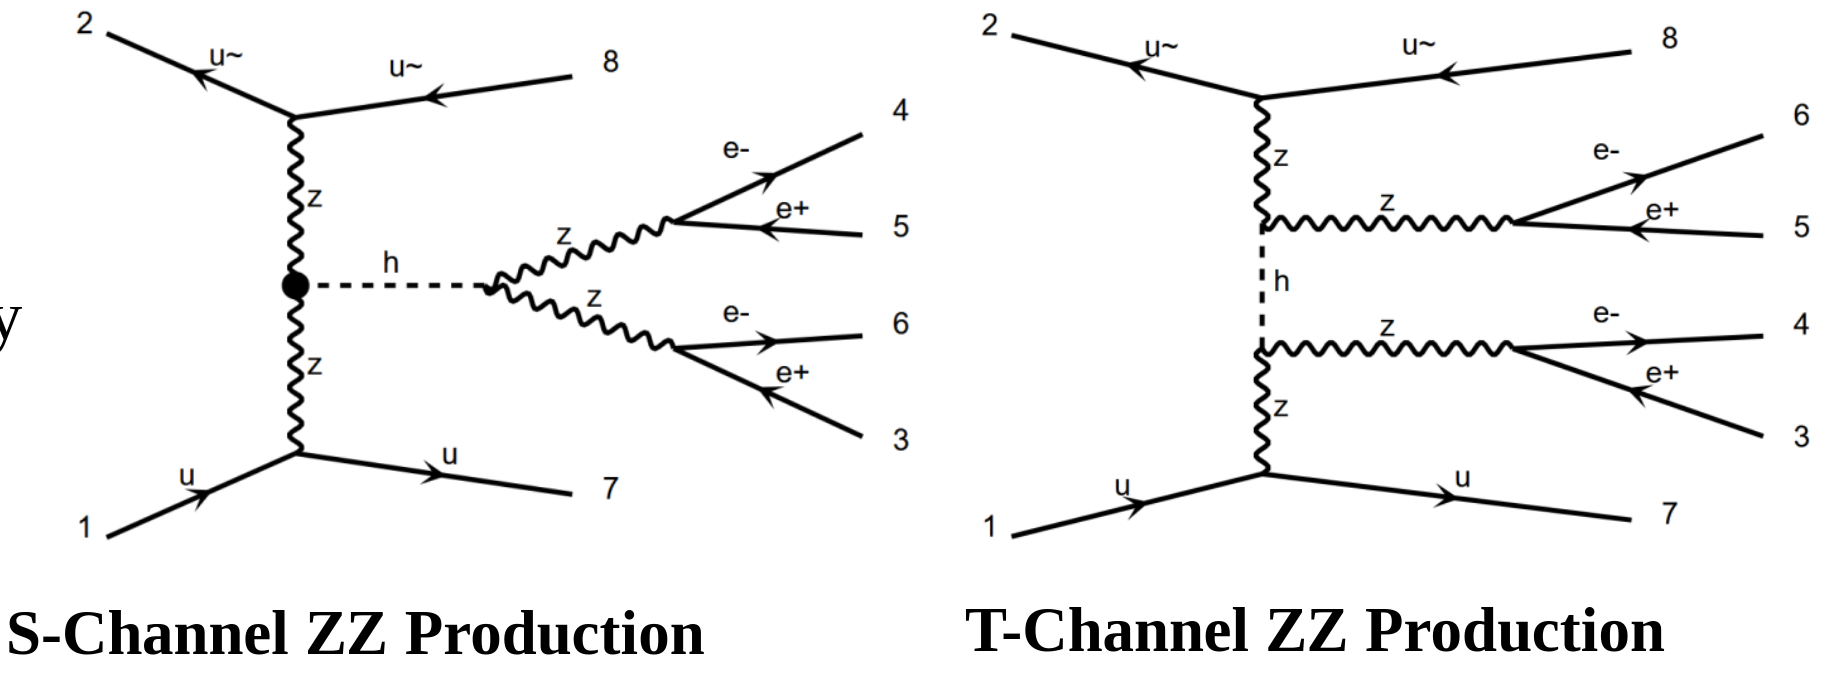

# A Few More Functions To Ponder

There are a bunch of other functions that MELA can offer (all of which are available for you to see [at the documentation](https://spin.pha.jhu.edu/MELA/classMela.html). Here are just a few examples:

- [SetCandidateDecayMode](https://spin.pha.jhu.edu/MELA/classMela.html#a56c78e0f627c65fbff7f312ff373bbad) allows you to set the decay mode. WW decay exists, but is currently ***not** fully tested*

- [ResetMass](https://spin.pha.jhu.edu/MELA/classMela.html#aed49296bc1ba9b4f0747b032d5089aef) and [ResetWidth](https://spin.pha.jhu.edu/MELA/classMela.html#adbd3569fc8446ccfe31d6cf4cf1c2d49) allow you to reset the mass and width of a variety of particles

- setMelaHiggs{[Mass](https://spin.pha.jhu.edu/MELA/classMela.html#aa835c3b33ddec39682776bb1cf98176b), [Width](https://spin.pha.jhu.edu/MELA/classMela.html#ac08cf6732bf5c84fa3da1c5252d2660f), [MassWidth](https://spin.pha.jhu.edu/MELA/classMela.html#a89930f849726aa1ffd4b38830df7a083)} sets the mass and width of the Higgs specifically - this is useful for high mass analyses


There are also more angles to deal with! All angles are found at [arXiv:1001.3396](https://arxiv.org/abs/1001.3396) and [arXiv:1208.4018](https://arxiv.org/abs/1208.4018). These are computed via:

- [computeDecayAngles](https://spin.pha.jhu.edu/MELA/classMela.html#a7ed076cbbb4121926e53f56cb4d56bab)
- [computeVBFAngles](https://spin.pha.jhu.edu/MELA/classMela.html#a888f07999471870590557aa4fec74caa)
- [computeVHAngles](https://spin.pha.jhu.edu/MELA/classMela.html#a4b68e6c2c5b1f430d6f88bc048137e88)

# Repeat after me - I affirm that I understand the phase-space issues when reweighting signal to background, and will be appropriately cautious moving forwards when reweighting anything

In [ ]:
#Your Python digital signature
i_affirm = False
assert i_affirm
tracker.affirm_pass()

# That's All Folks

## Please make your way towards the tutorial on observables next!